In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import structify_net as stn
import structify_net.viz as viz
import structify_net.zoo as zoo
import structify_net.scoring as scoring

# Introduction to Structify_Net
Structify_Net is a network generator provided as a python library.

It allows to generate networks with:
* A chosen number of nodes and edges
* A chosen structure
* A constrolled amount of randomness

## Step 1: Graph properties definition
We start by defining the number of nodes and edges that we want

In [199]:
n=128
m=512

## Step 2: Structure definion
We start by defining a structure, by ordering the pairs of nodes in the graph from the most likely to appear to the less likely to appear. For instance, if we assume that our network is a spatial network, and that each node has a position in an euclidean space, we can define that the pairs of nodes are ranked according to their distance in this space.

Many classic structures are already implemented in Structify-Net. For the sake of example, here we define a very simple organisation, which actually correspond to a nested structure, by defining a sorting function. This simple function only requires the nodes ids. we could provide node attributes in the third parameter.

In [200]:
def R_nestedness(u,v,_):
    return u+v

We then generate a Rank_model object using Structify-net

In [201]:
rank_nested = stn.Rank_model(n,R_nestedness)

A way to visualize the resulting structure is to plot the node pairs order as a matrix

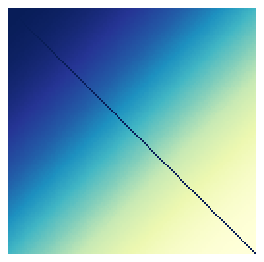

In [202]:
figure(figsize=(4, 4), dpi=80)

rank_nested.plot_matrix()

## Step 3: Edge probability definition
Now that we know which node pairs are the most likely to appear, we need to define a function $f$ that assign edge probabilities on each node pair, by respecting some constraints: 
* The expected number of edges must be equal to the chosen parameter `m`, i.e. $\sum_{u,v\in G}f(rank(u,v))=m$
* For any two node pairs $e_1$ and $e_2$, if $rank(e_1)>rank(e_2)$, then $f(e_1)\geq f(e_2)$

Although any such function can be provided, Structify-net provides a convenient function generator, using a constraint parameter $\epsilon \in [0,1]$, such as 0 corresponds to a deterministic structure, the m pairs of highest rank being connected by an edge, while 1 corresponds to a fully random network.

In [203]:
probas = rank_nested.get_generator(epsilon=0.5,m=m)

We can plot the probability as a function of rank for various values of `epsilon` 

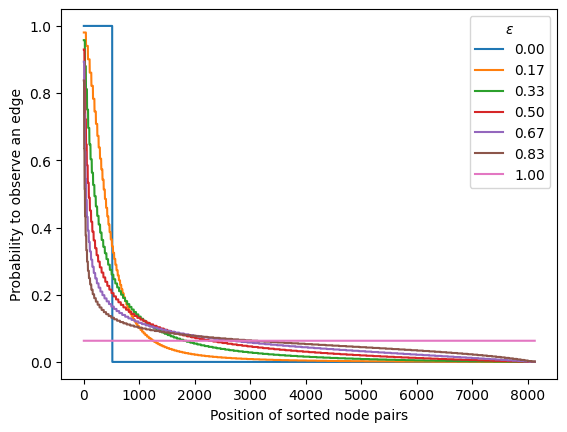

In [204]:
fig, ax = plt.subplots()
for epsilon in np.arange(0,1.1,1/6):
    probas = rank_nested.get_generator(epsilon=epsilon,m=m)
    elt = probas.plot_proba_function(ax=ax)
    #elt=viz.plot_proba_function(probas,ax=ax)
    elt[-1].set_label(format(epsilon, '.2f'))
    #fig_tem.plot(label="pouet"+str(epsilon))
ax.legend(title="$\epsilon$")


## Step 4: Generate a graph from edge probabilities


In [205]:
generator = rank_nested.get_generator(epsilon=0.5,m=m)
g_generated = generator.generate()

<AxesSubplot: >

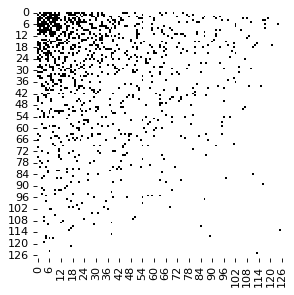

In [206]:
figure(figsize=(4, 4), dpi=80)
viz.plot_adjacency_matrix(g_generated)

## Whole process in a function
The whole process of graph generation from a desired number of nodes and edges can be done in a single function

In [207]:
g_example = rank_nested.generate_graph(epsilon=0,m=500)

## Structure Zoo
StructifyNet already implement various graph structure. They are exemplified below

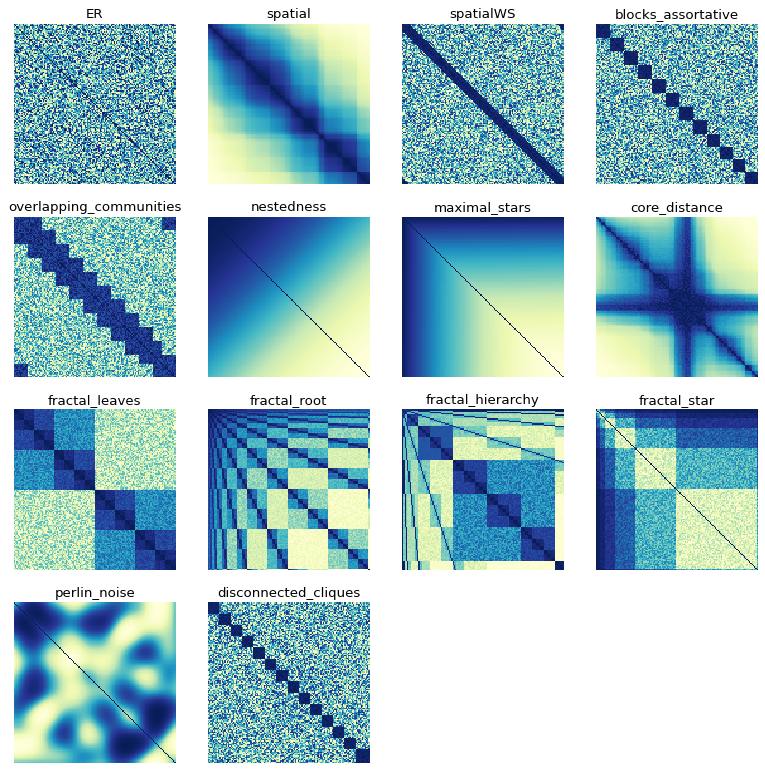

In [228]:
n=128
m=512
figure(figsize=(12, 12), dpi=80)
for i,(name,rank_model) in enumerate(zoo.get_all_rank_models(n=128,m=m).items()):
    ax = plt.subplot(4,4,i+1 )
    
    rank_model.plot_matrix()
    
    ax.set_title(name)


## Graph description
Models generate graphs having specific properties.
Structify-Net includes various scores that can be used to characterize networks --and the model generating them.

### Getting Started: replicating Watts-Strogatz Small World experiment
The famous small world experiments consisted in generating networks with a locally clustered structure (nodes are located on a ring and connected to their neighbors), and then introducing progressively random noise, until reaching a random network.
The *small world regime* corresponds to the level of noise for which the clustering coefficient is still high -as in the locally clustered network- but the average shortest path is already low -as in a random network.

In [229]:
n=1000
m=n*5
WS_model = zoo.sort_spatial_WS(n,k=10) #k is the nodes degree
df_scores = WS_model.scores(m=m,
                scores={"clustering":scoring.average_clustering,
                        "short paths":scoring.average_shortest_path_length},
                epsilons=np.logspace(-4,0,10),latex_names=False)
df_scores.head(3)

Epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

,name,clustering,short paths,epsilon
0,model,0.664838,0.043552,0.000100
1,model,0.663089,0.055966,0.000278
2,model,0.657589,0.092717,0.000774


### Plotting the results
We can observe the small world regime by plotting the evolution of both values as a function of `epsilon`.
Note that the `short paths` is defined in a different way than in the original article, to be more generic. It corresponds to the inverse of the average distance, normalized such as `short paths`=1 for a network with a complete star, such as each node is at distance 2 from all other node. 

<AxesSubplot: xlabel='epsilon'>

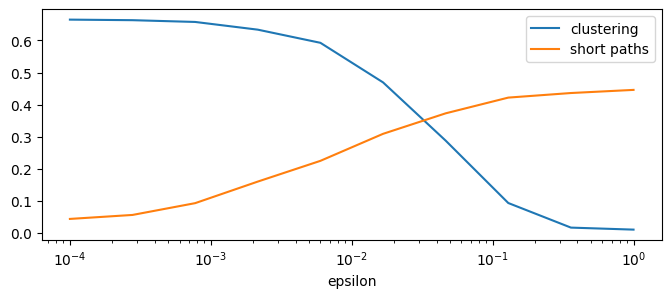

In [230]:
df_scores.plot(x="epsilon",logx=True,figsize=(8, 3))

### Small World regime for other structures
We can replicate this experiment for all structures in our structure zoo

In [231]:
df_scores = scoring.scores_for_rank_models(zoo.get_all_rank_models(n,m),m=m,
                       scores={"clustering":scoring.average_clustering,
                               "short paths":scoring.average_shortest_path_length},
                       epsilons=np.logspace(-4,0,10),latex_names=False)                  

Epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

In [232]:
df_scores.head()

,name,clustering,short paths,epsilon
0,ER,0.009857,0.444096,0.0001
1,blocks_assortative,0.329946,0.000000,0.0001
2,core_distance,0.112838,0.000000,0.0001
3,disconnected_cliques,0.978983,0.000000,0.0001
4,fractal_hierarchy,0.829898,0.971546,0.0001


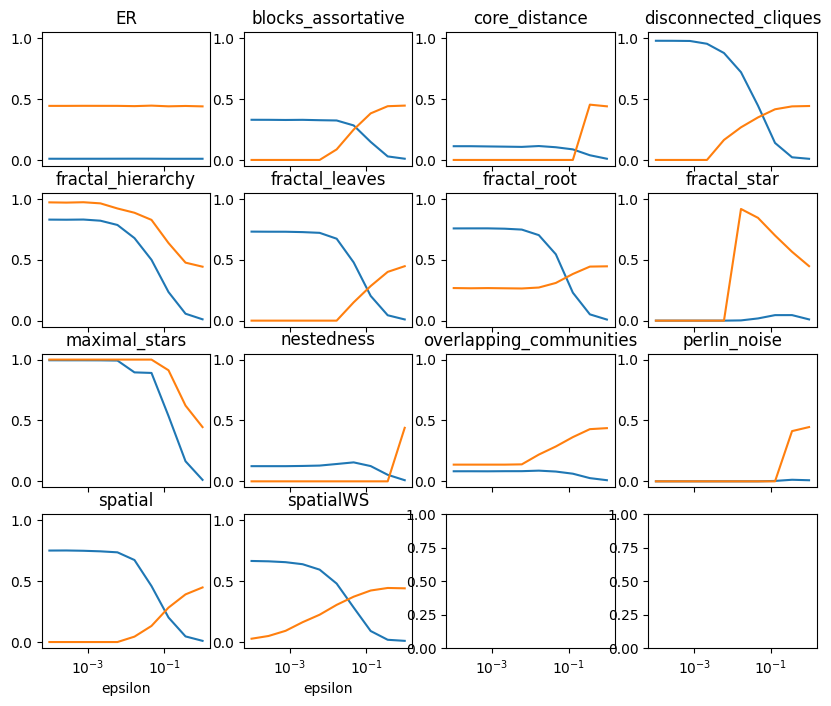

In [233]:
g = df_scores.groupby('name')

fig, axes = plt.subplots(4,4, sharex=True)
all_axes = axes.flatten()
for i, (name, d) in enumerate(g):
    ax = d.plot.line(x='epsilon', ax=all_axes[i], title=name,logx=True,figsize=(10, 8))
    ax.set_ylim(-0.05,1.05)
    ax.legend().remove()


Note: the **orange curve** corresponds to short path index, and **blue curve** to the clustering coefficient.

## Models Profiling
Average distance and Average clustering are only two examples of graph structure descriptors. Structify-Net contains several other descriptors. We can use them to show more details of the evolution from the regular grid to the random network

In [2]:
detail_evolution = zoo.sort_spatial_WS(500).scores(m=500*5,epsilons=np.logspace(-4,0,6),scores=scoring.get_default_scores(),latex_names=True)
#detail_evolution = toolBox.scores_for_rank_functions({"spatialWS":zoo.sort_spatial_WS},500,500*5,epsilons=np.logspace(-4,0,6),scores=toolBox.get_all_scores())

Epsilon:   0%|          | 0/6 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

In [215]:
detail_evolution

,name,$CC(G)$,$\overline{CC(u)}$,Core,$\overline{d}$,Rob,I,$Q$,$Q_{bound}$,$\sigma(k)$,$$-(k \propto k)$$,$${k \propto CC}$$,$\epsilon$
0,model,0.666075,0.666182,0.200000,0.046832,1.00,1.0,0.777533,0.260278,0.000398,0.0,0.0,0.000100
1,model,0.656600,0.657631,0.183673,0.108350,0.98,1.0,0.773530,0.224972,0.008416,0.0,0.0,0.000631
2,model,0.626598,0.631821,0.163265,0.206054,0.98,1.0,0.764524,0.238881,0.030597,0.0,0.0,0.003981
3,model,0.447929,0.466216,0.142857,0.355655,0.98,1.0,0.654202,0.217358,0.077708,0.0,0.0,0.025119
4,model,0.105552,0.113990,0.142857,0.481359,1.00,1.0,0.268974,0.172912,0.141030,0.0,0.0,0.158489
5,model,0.017456,0.016949,0.140000,0.518599,0.98,1.0,0.021596,0.070055,0.163151,0.0,0.0,1.000000


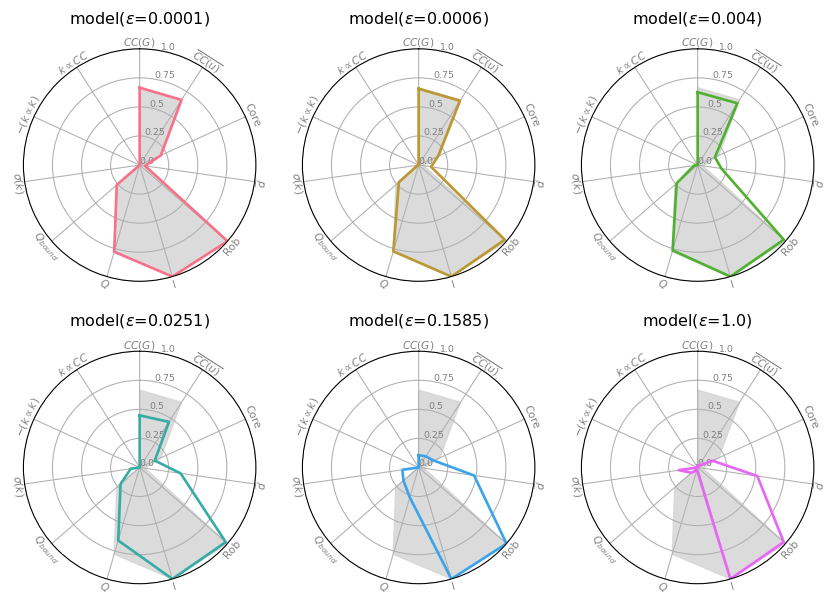

In [216]:
viz.spider_plot(detail_evolution,reference=0)

### We can also compare properties of a set of models
In this case, we plot all models in Structify's Zoo, with `epsilon`=0

In [217]:
n,m=128,128*8
detail_evolution = scoring.scores_for_rank_models(zoo.get_all_rank_models(n,m),m,epsilons=0,latex_names=True)

Epsilon:   0%|          | 0/1 [00:00<?, ?it/s]

Run:   0%|          | 0/1 [00:00<?, ?it/s]

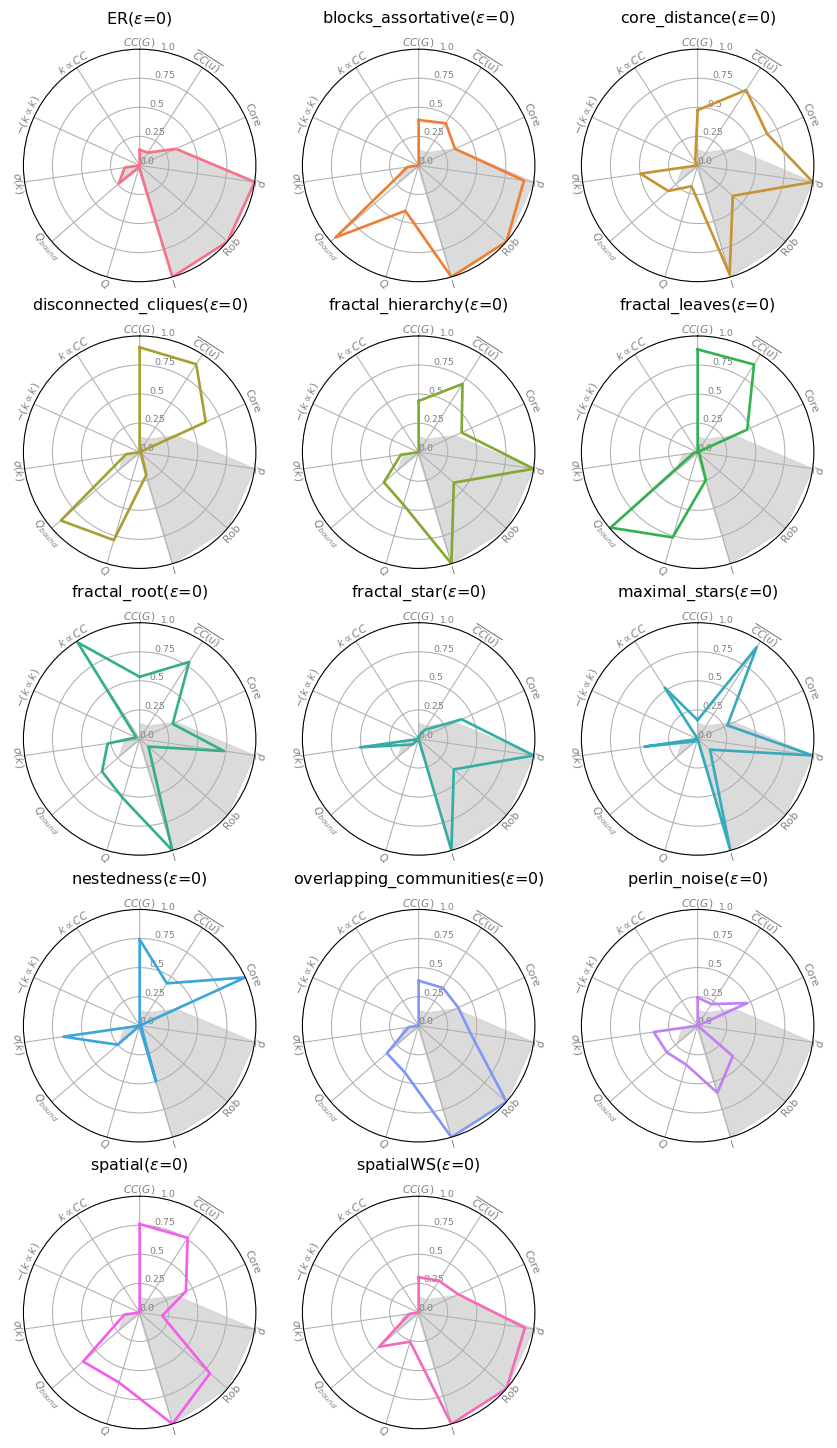

In [218]:
viz.spider_plot(detail_evolution,reference=0)

## Comparing with an observed network
If we are interested in a particular network, we can compare the structure of that network with the strucuture of some candidate models in our strucuture zoo.
For instance, let us check the structure of the Zackary karate club graph

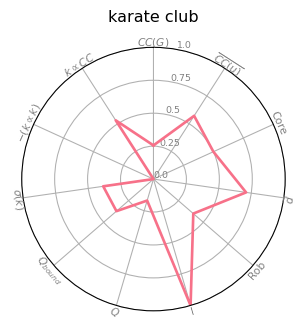

In [219]:
karate_scores = scoring.scores_for_graphs({"karate club":nx.karate_club_graph()},latex_names=True)
viz.spider_plot(karate_scores)

### Generate graphs of the same size
We generate graphs using the structures in the zoo, varying the epsilon parameter, but keeping the same number of nodes and (expected) edges than in the target graph. To get more reliable results, we take the average values over multiple runs.

Since the karate club graph is often interpreted in term of communities, we include two additional versions of the structures, that can be parameterized with the number of blocks.

In [220]:
n=nx.karate_club_graph().number_of_nodes()
m=nx.karate_club_graph().number_of_edges()
models_to_compare=zoo.get_all_rank_models(n,m)

louvain_communities=nx.community.louvain_communities(nx.karate_club_graph())
models_to_compare["louvain"]=zoo.sort_blocks_assortative(n,blocks=louvain_communities)
models_to_compare["com=2"]=zoo.sort_blocks_assortative(n,blocks=2)
epsilons=np.logspace(-3,0,10)


In [221]:
compare_scores = scoring.scores_for_rank_models(models_to_compare,m,epsilons=epsilons,runs=20)

Epsilon:   0%|          | 0/10 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

Run:   0%|          | 0/20 [00:00<?, ?it/s]

#### Comparing
We compute the $L_1$ distance (sum of differences in each score) between the observed graph and the models.
We can explore how the models' similarity evolve as a function of the random parameter

In [222]:
compare = scoring.compare_graphs(karate_scores,compare_scores,best_by_name=False,score_difference=True)

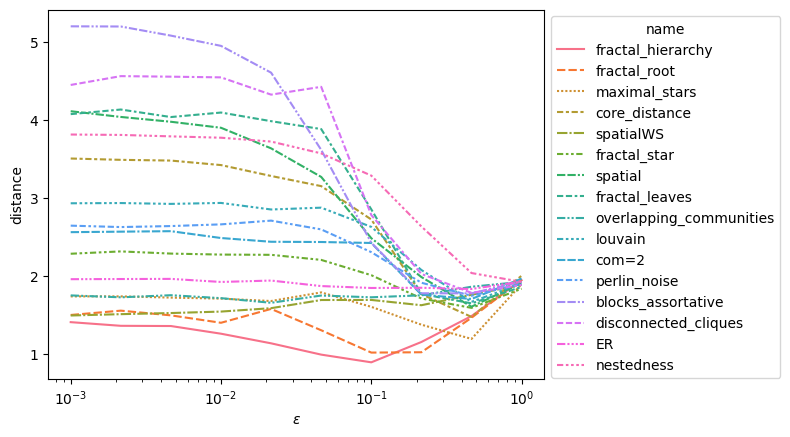

In [223]:
ax = sns.lineplot(data=compare,x="$\epsilon$",y="distance",hue="name",style="name",palette=sns.color_palette("husl", len(models_to_compare)))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('log')

## Details of models matching
We can study in more details what properties does each model captures or not.
We select for each model the value of epsilon giving the best match. Models are also sorted according the distance, so that the first models returned are the most similar, and then we plot the properties of those selected models, with the properties of our graph for comparison

In [224]:
compare = scoring.compare_graphs(karate_scores,compare_scores,best_by_name=True,score_difference=False)

In [225]:
compare.head()

,name,$CC(G)$,$\overline{CC(u)}$,Core,$\overline{d}$,Rob,I,$Q$,$Q_{bound}$,$\sigma(k)$,$$-(k \propto k)$$,$${k \propto CC}$$,$\epsilon$,distance
0,fractal_hierarchy,0.280471,0.564375,0.461806,0.869461,0.254,0.992647,0.132835,0.414314,0.319198,0.000000,0.159376,0.100000,0.898688
1,fractal_root,0.440271,0.622941,0.425000,0.557126,0.418,0.998529,0.302972,0.476464,0.279551,0.043807,0.681881,0.100000,1.023490
2,maximal_stars,0.226890,0.423235,0.449306,0.882993,0.400,0.970588,0.000000,0.285450,0.439384,0.000000,0.070655,0.464159,1.198892
3,core_distance,0.280774,0.240385,0.527778,0.606878,0.600,0.957353,0.007563,0.369889,0.362630,0.039165,0.004190,0.464159,1.481096
4,spatialWS,0.314400,0.282437,0.500000,0.547238,0.600,1.000000,0.198066,0.412887,0.195659,0.000000,0.000000,0.001000,1.498977


In [226]:
compare_plot=compare.drop(columns=["distance"])
compare_plot.loc[-1, :] = karate_scores.iloc[0]
compare_plot.sort_index(inplace=True) 

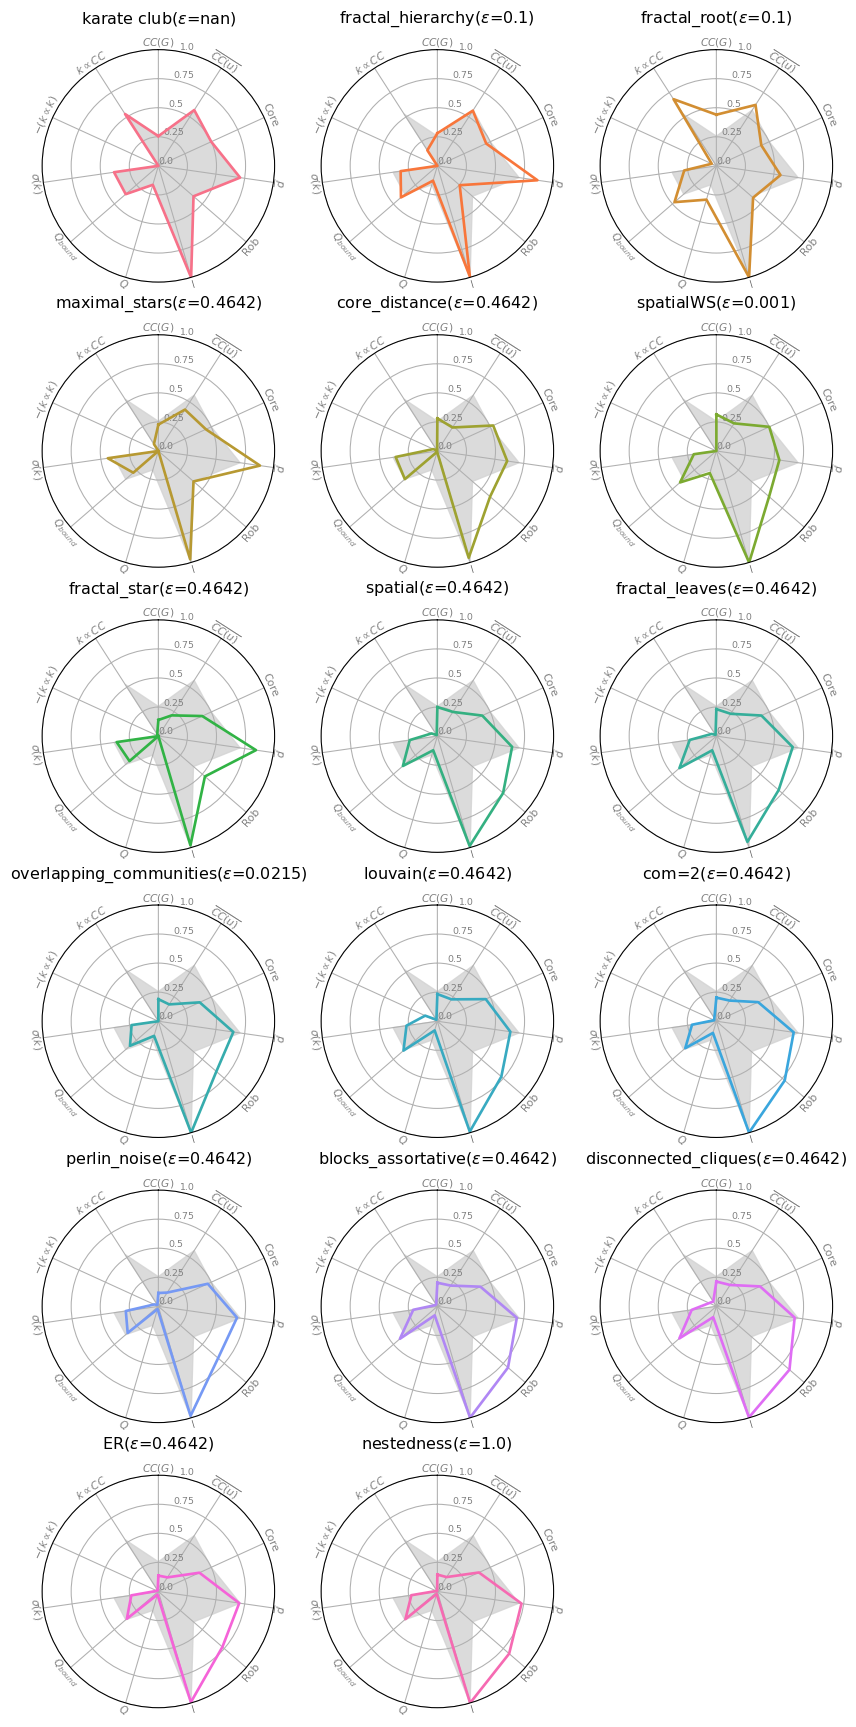

In [227]:
viz.spider_plot(compare_plot,reference=0)